In [177]:
import numpy as np
from numpy.linalg import norm 

import seaborn as sns
import matplotlib as mpl

# Theme and Font
sns.set_theme(style="whitegrid", context="talk", palette="deep")
mpl.rcParams.update({
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "figure.autolayout": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "STIXGeneral", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    # Sizes
    "axes.titlesize": 15,
    "axes.labelsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 12,
    # Lines / markers
    "lines.linewidth": 1.8,
    "lines.markersize": 6,
    "lines.markeredgewidth": 0.8,
    # Axes / grid
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.linewidth": 0.8,
    "grid.color": "#e6e6e6",
    "axes.edgecolor": "#333333",
    "axes.spines.top": False,
    "axes.spines.right": False,
    # Ticks
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    # Legend
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "legend.fancybox": True,
    "legend.edgecolor": "#444444",
    # Color cycle
    # "axes.prop_cycle": mpl.cycler(color=sns.color_palette("colorblind").as_hex())
})


# helpers 


In [178]:
def comm(A, B):
    return A @ B - B @ A

def uniform_state(n):
    return np.ones((n, 1), dtype=complex) / np.sqrt(n)

def random_state(n):
    x = np.random.randn(n, 1) + 1j * np.random.randn(n, 1)
    return x / norm(x)

def hs_inner_real(X, Y):
    """Real Hilbert–Schmidt inner product: <X,Y> = Re(tr(X* Y))."""
    return float(np.real(np.trace(X.conj().T @ Y)))

def frob_norm(X):
    """Frobenius norm."""
    return np.sqrt(hs_inner_real(X, X))

# setting

In [179]:
# grover algo 中的 H, psi_0
def projector_on_S(N, S):
    H = np.zeros((N, N), dtype=complex)
    for x in S:
        H[x, x] = 1.0
    return H

def target_state_on_S(N, S):
    M = len(S)
    v_target = np.zeros(N, dtype=complex)
    for x in S:
        v_target[x] = 1.0
    return v_target / np.sqrt(M)

# Grover algo H
n = 6 # qubits
N = 2**n
M=2
S = np.random.choice(N, size=M, replace=False)
H = projector_on_S(N, S)
target_state = target_state_on_S(N, S)

In [180]:
## intial state setting! 

# 1. random state
# psi_0_vec = random_state(N) ########

# 2. uniform state
psi_0_vec = uniform_state(N) ########
psi_0 = psi_0_vec @ psi_0_vec.conj().T

# iteration

In [181]:
def gamma5(t, x, y, H, psi0, delta=np.pi):
    # set delta = np.pi gives the original 5-factor retraction
    I = np.eye(H.shape[0], dtype=complex)
    
    def E_P(theta, P):
        # For a projector P: exp(i theta P) = I + (e^{i theta}-1) P
        return I + (np.exp(1j * theta) - 1.0) * P

    def E_psi(theta): return E_P(theta, psi0)
    def E_H(theta):   return E_P(theta, H)

    A = np.arctan2(y, x)
    R = np.sqrt(x*x + y*y)
    a1, a2 = A + delta/2, A - delta/2
    b1, b2 = -0.5*R/(2*np.sin(delta/2)), 0.5*R/(2*np.sin(delta/2))
    
    V = E_H(a1) @ E_psi(b1*t) @ E_H(a2 - a1) @ E_psi(b2*t) @ E_H(-a2)

    return V

In [182]:
psi_k_vec = psi_0_vec.copy()
psi_k = psi_0.copy()

X_list = []
q_list = []
fid_list = []
X_norm_list = []
X0 = comm(H, psi_0)
Y0 = 1j*comm(H, X0)
q0 = float(np.real(np.trace(H @ psi_0)))
tau0 = np.sqrt(q0*(1-q0))

# Start
q = q0
tol=1e-4
K=2000 ######## iterations

print(f"{'Iter':>4} | {'q_k':>8} | {'t_k':>8} | {'fid':>7} | {'grad_k_norm':>7}")
print("-" * 90)

t = 1
while True:
    # Current fidance to target
    # fidelity
    fid = np.abs(np.vdot(psi_k_vec, target_state))**2
    fid_list.append(fid)

    # Current scalars
    q_k = np.real(np.trace(psi_k @ H))
    q_list.append(q_k)

    # Current gradient
    grad_k = comm(H, psi_k)
    grad_k_norm = frob_norm(grad_k)
    X_norm_list.append(grad_k_norm)

    # step size!
    # t_k = 0.1
    L_Rie = 2 + N/ np.sqrt(2 * M * (N - M))
    t_k = 1/L_Rie
    
    x = hs_inner_real(grad_k, X0)/(2* tau0**2)
    y = hs_inner_real(grad_k, Y0)/(2* tau0**2)
    
    Update_gate = gamma5(t_k, x, y, H, psi_0, delta=np.pi)
    
    # Update state
    psi_k_vec = Update_gate @ psi_k_vec
    psi_next = Update_gate @ psi_k @ Update_gate.conj().T
    psi_k = psi_next.copy()

    # formatted print
    print(f"{t:4d} | {q_k:8.5f} | {t_k:8.5f} | {fid:8.5f} | {grad_k_norm:8.5f}")

    t += 1

    if abs(1 - q_k) < tol or t >= K + 1: 
        break

Iter |      q_k |      t_k |     fid | grad_k_norm
------------------------------------------------------------------------------------------
   1 |  0.03125 |  0.16491 |  0.03125 |  0.24606
   2 |  0.03643 |  0.16491 |  0.03643 |  0.26498
   3 |  0.04244 |  0.16491 |  0.04244 |  0.28510
   4 |  0.04939 |  0.16491 |  0.04939 |  0.30644
   5 |  0.05742 |  0.16491 |  0.05742 |  0.32900
   6 |  0.06666 |  0.16491 |  0.06666 |  0.35276
   7 |  0.07728 |  0.16491 |  0.07728 |  0.37765
   8 |  0.08944 |  0.16491 |  0.08944 |  0.40358
   9 |  0.10331 |  0.16491 |  0.10331 |  0.43043
  10 |  0.11907 |  0.16491 |  0.11907 |  0.45802
  11 |  0.13689 |  0.16491 |  0.13689 |  0.48610
  12 |  0.15692 |  0.16491 |  0.15692 |  0.51439
  13 |  0.17932 |  0.16491 |  0.17932 |  0.54252
  14 |  0.20418 |  0.16491 |  0.20418 |  0.57007
  15 |  0.23158 |  0.16491 |  0.23158 |  0.59657
  16 |  0.26150 |  0.16491 |  0.26150 |  0.62148
  17 |  0.29390 |  0.16491 |  0.29390 |  0.64424
  18 |  0.32861 |  0.1649

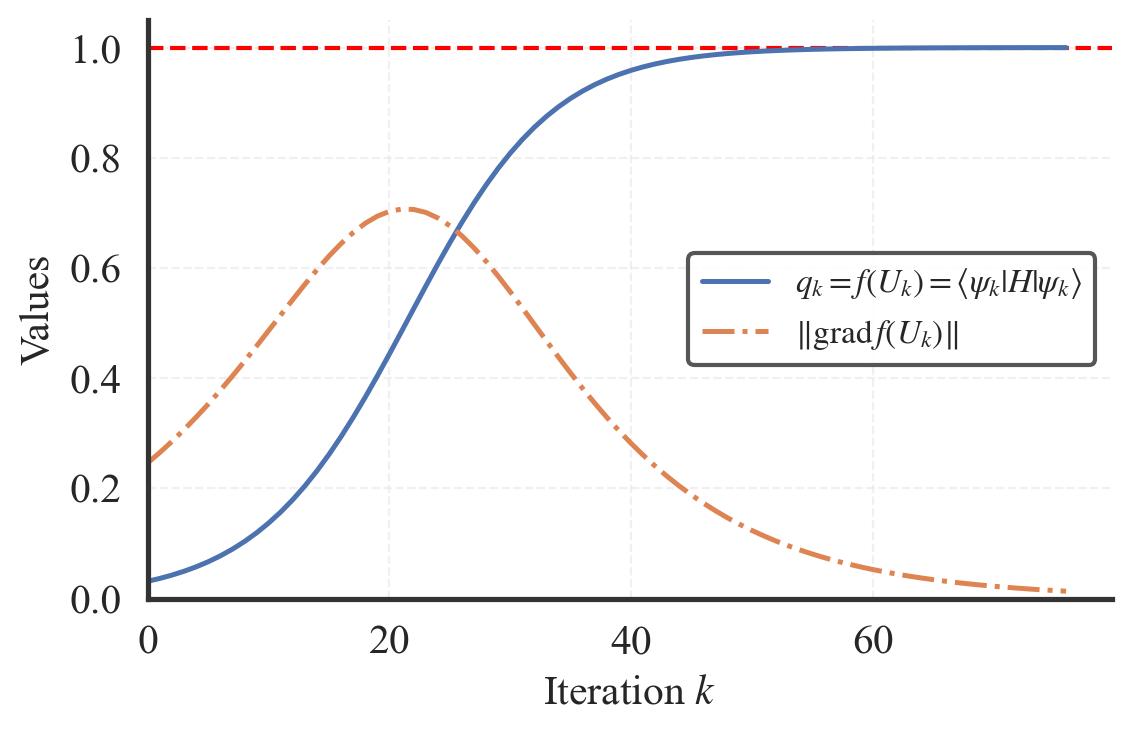

In [188]:
import matplotlib.pyplot as plt

# ---- Plot q_k after iterations ----
plt.figure(figsize=(6,4))
K=len(q_list)
max_eigenvalue = float(np.max(np.real(np.linalg.eigvals(H))))
plt.axhline(y=max_eigenvalue, color="red", linestyle="--", linewidth=1.5)
plt.plot(range(K), q_list, label=r"$q_k = f(U_k) = \langle \psi_k | H |\psi_k \rangle$", linestyle="-")
plt.plot(range(K), X_norm_list, label=r"$\|\operatorname{grad} f(U_k)\|$", linestyle="-.")
# plt.plot(range(K), fid_list, label=r"$\operatorname{Fid}_k=1- \left| \langle\psi_{k} | \psi^{\star}\rangle \right|^2$", linestyle="-.")
# plt.axhline(y=diag_opt, color="red", linestyle="--", linewidth=1.5, label="y=diag_opt")


plt.xlabel(r"Iteration $k$")
# plt.ylabel(r"$q_k = \mathrm{Tr}(\psi_k H)$")
plt.ylabel(r"Values")
# plt.title("Evolution of q_k over iterations")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.xlim(0)
plt.ylim(-0.00, 1.05)
plt.savefig("evolution_qk_fid_gradnorm.png")
plt.show()